In [ ]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
dataset_path = r"C:\Users\DELL\Desktop\BloodGroupDetectionUsingFingerPrint\BloodGroupDetectionUsingFingerPrint\dataset\dataset_blood_group"

In [ ]:
import os
dataset_path = r"C:\Users\DELL\Desktop\BloodGroupDetectionUsingFingerPrint\BloodGroupDetectionUsingFingerPrint\dataset\dataset_blood_group"



if not os.path.exists(dataset_path):
    print("Dataset path does not exist!")


print("Dataset folders:", os.listdir(dataset_path))


Dataset folders: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B--', 'O+', 'O-']


In [5]:
BATCH_SIZE = 32

In [ ]:

from tensorflow.keras.utils import image_dataset_from_directory
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64, 64), 
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [ ]:

class_names = dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution:
A-: 1009
B--: 762
O+: 852
AB+: 652
B+: 708
O-: 712
AB-: 740
A+: 565


In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]


    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title('Dataset Class Distribution', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()


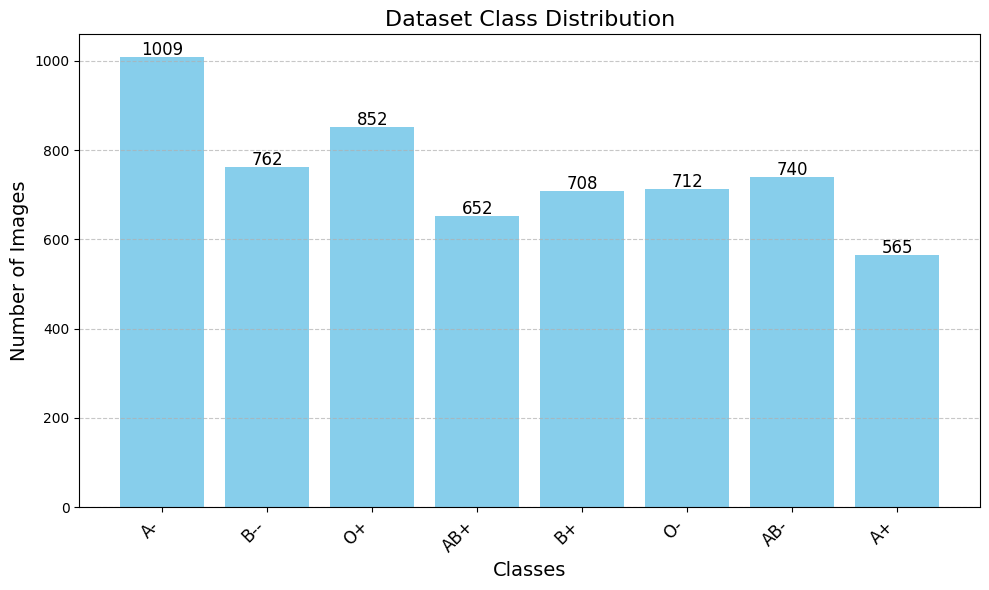

In [ ]:
plot_class_distribution(class_names, class_counts)


In [10]:
max_count = max(class_counts.values())

In [ ]:
def oversample_class(class_id, count, max_count):
    unbatched_dataset = dataset.unbatch()
    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))
    repeat_factor = max_count // count + (max_count % count > 0)
    return class_dataset.repeat(repeat_factor).take(max_count)


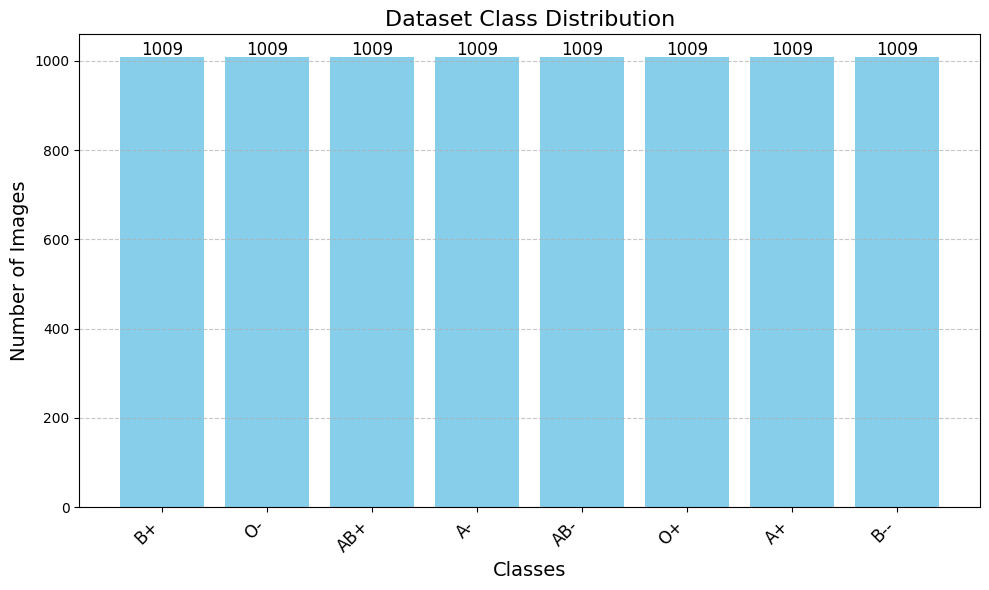

In [ ]:

balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)
balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)
balanced_dataset = balanced_dataset.batch(BATCH_SIZE,drop_remainder=True)


In [13]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)


(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [14]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")


Total dataset size: 8064


In [ ]:

train_ratio = 0.7  
val_ratio = 0.2     
test_ratio = 0.1    

import math
assert math.isclose(train_ratio + val_ratio + test_ratio, 1.0, rel_tol=1e-9), "Ratios must sum to 1.0"

balanced_dataset_unbatched = balanced_dataset.unbatch()

dataset_size = sum(1 for _ in balanced_dataset_unbatched)

print(f"Total dataset size: {dataset_size}")  

balanced_dataset_unbatched = balanced_dataset.unbatch()


train_size = int(train_ratio * dataset_size)  
val_size = int(val_ratio * dataset_size)      
test_size = dataset_size - (train_size + val_size)  

train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)


train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")  
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")  
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")    


Total dataset size: 8064
Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


In [ ]:

def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'), 
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



high_acc_model = create_high_accuracy_model()




c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          
    factor=0.5,               
    patience=3,                  
    verbose=1,                   
    min_lr=1e-6                  
)

early_stop = EarlyStopping(
    monitor='val_loss',         
    patience=5,                 
    verbose=1,                   
    restore_best_weights=True    
)


In [ ]:


history_high_acc = high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  
    callbacks=[reduce_lr, early_stop]
    
)



Epoch 1/10
    176/Unknown 39s 201ms/step - accuracy: 0.1286 - loss: 36.4752

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


176/176 ━━━━━━━━━━━━━━━━━━━━ 58s 309ms/step - accuracy: 0.1286 - loss: 36.3238 - val_accuracy: 0.1275 - val_loss: 2.0390 - learning_rate: 0.0010
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 53s 298ms/step - accuracy: 0.1452 - loss: 2.0786 - val_accuracy: 0.1275 - val_loss: 2.0383 - learning_rate: 0.0010
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 53s 299ms/step - accuracy: 0.2018 - loss: 2.0106 - val_accuracy: 0.1281 - val_loss: 2.0009 - learning_rate: 0.0010
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 58s 328ms/step - accuracy: 0.3406 - loss: 1.7400 - val_accuracy: 0.1275 - val_loss: 2.1078 - learning_rate: 0.0010
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 56s 312ms/step - accuracy: 0.4924 - loss: 1.3354 - val_accuracy: 0.2365 - val_loss: 2.0002 - learning_rate: 0.0010
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 55s 311ms/step - accuracy: 0.5815 - loss: 1.1164 - val_accuracy: 0.5141 - val_loss: 1.3356 - learning_rate: 0.0010
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 58s 327ms/step - accuracy: 0.6164 - loss

In [ ]:

high_acc_eval = high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.7930 - loss: 0.8533
High Accuracy Model - Loss: 0.8430269956588745, Accuracy: 0.7708333134651184


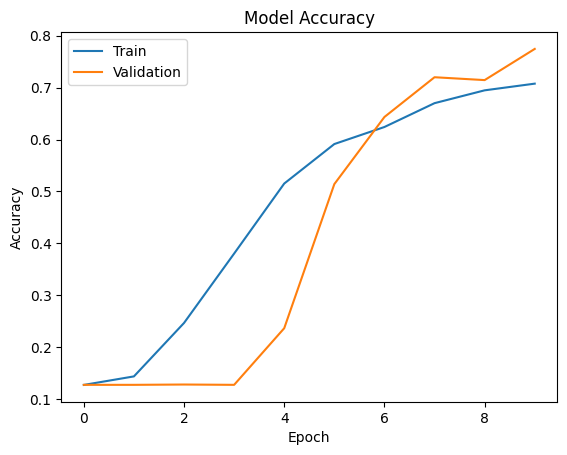

In [ ]:
import matplotlib.pyplot as plt


def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


plot_accuracy(history_high_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Classification Report:
              precision 

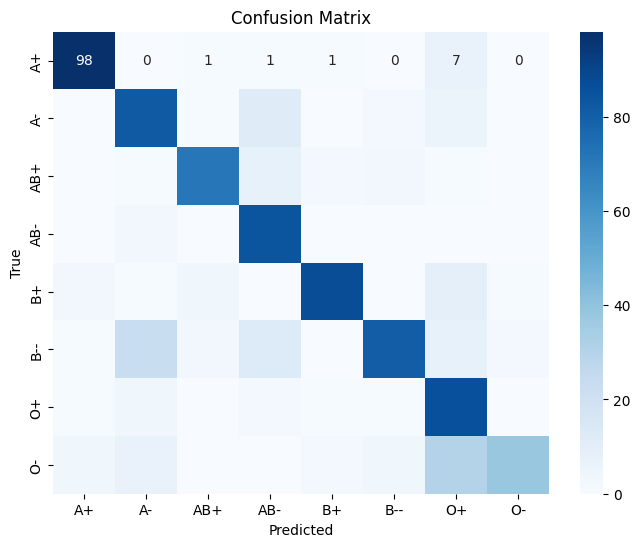

In [ ]:

y_true = []  
y_pred = []  

for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())  
    y_pred.extend(predicted_labels)  


y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)


conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
import os

save_path = os.path.abspath("model.h5")  
print("Model will be saved at:", save_path)


Model will be saved at: c:\Users\DELL\Desktop\BloodGroupDetectionUsingFingerPrint\BloodGroupDetectionUsingFingerPrint\notebook\model.h5


In [ ]:
high_acc_model.save('model.h5') 
print("Model saved as HDF5 format.")

Model saved as HDF5 format.


In [24]:
pip show pillow

Name: Pillow
Version: 10.0.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Jeffrey A. Clark (Alex)
Author-email: aclark@aclark.net
License: HPND
Location: c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: 
Required-by: matplotlib, streamlit
Note: you may need to restart the kernel to use updated packages.


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


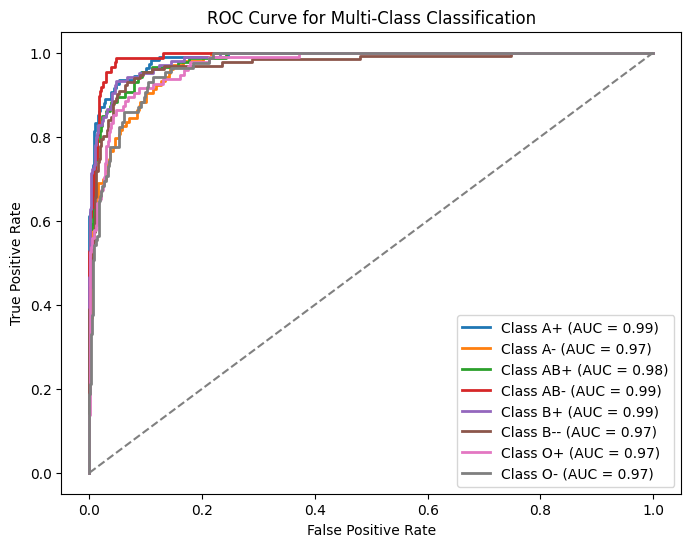

In [ ]:
#ROC CURVE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt


n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


y_pred_proba = high_acc_model.predict(test_dataset) 


plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])  
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


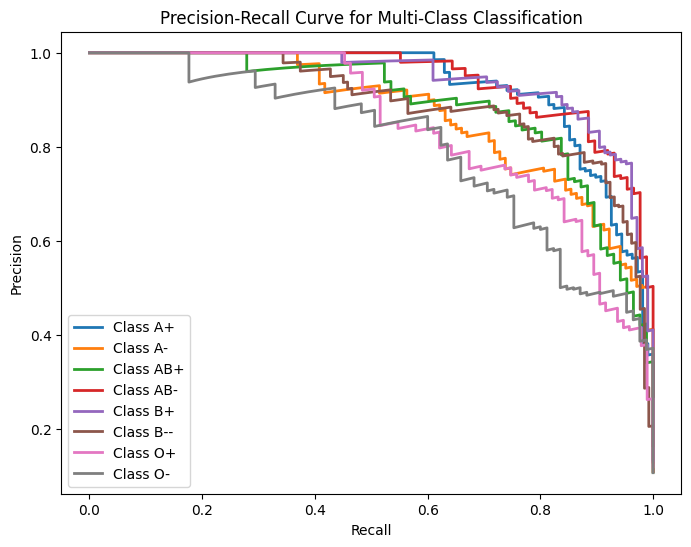

In [ ]:

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


y_pred_proba = high_acc_model.predict(test_dataset)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {class_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

class TemperatureScaling:
    def __init__(self, model, temp=1.0):
        self.model = model
        self.temp = temp

    def set_temperature(self, logits, y_true):
 
        import scipy.optimize

        def loss_fn(temp):
            scaled_probs = tf.nn.softmax(logits / temp, axis=1)
            return tf.keras.losses.sparse_categorical_crossentropy(y_true, scaled_probs).numpy().mean()

        opt_result = scipy.optimize.minimize_scalar(loss_fn, bounds=(0.5, 5), method='bounded')
        self.temp = opt_result.x
        print(f"Optimal temperature: {self.temp:.2f}")

    def predict_proba(self, logits):
        
        return tf.nn.softmax(logits / self.temp, axis=1).numpy()


logits = high_acc_model.predict(test_dataset)

y_true_np = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)

scaler = TemperatureScaling(high_acc_model)
scaler.set_temperature(logits, y_true_np)  
y_pred_calibrated = scaler.predict_proba(logits)  


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step
Optimal temperature: 0.50


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


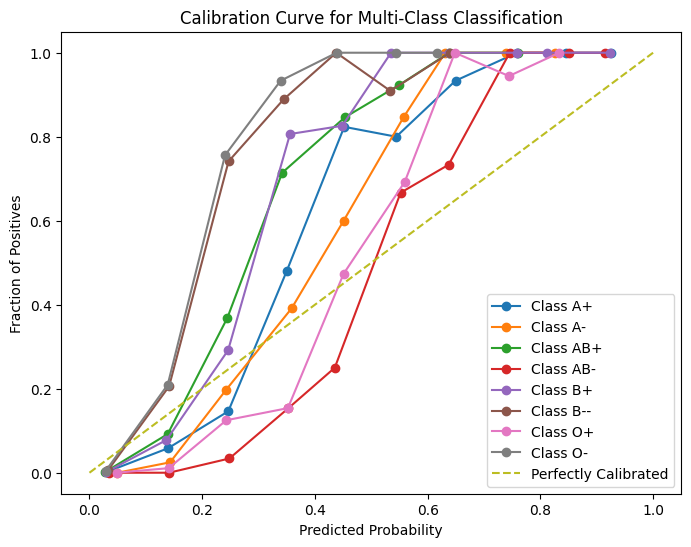

In [ ]:
#Calibration curve
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt


n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


y_pred_proba = high_acc_model.predict(test_dataset)


plt.figure(figsize=(8, 6))
for i in range(n_classes):
    prob_true, prob_pred = calibration_curve(y_true_bin[:, i], y_pred_proba[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_names[i]}')

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve for Multi-Class Classification')
plt.legend()
plt.show()


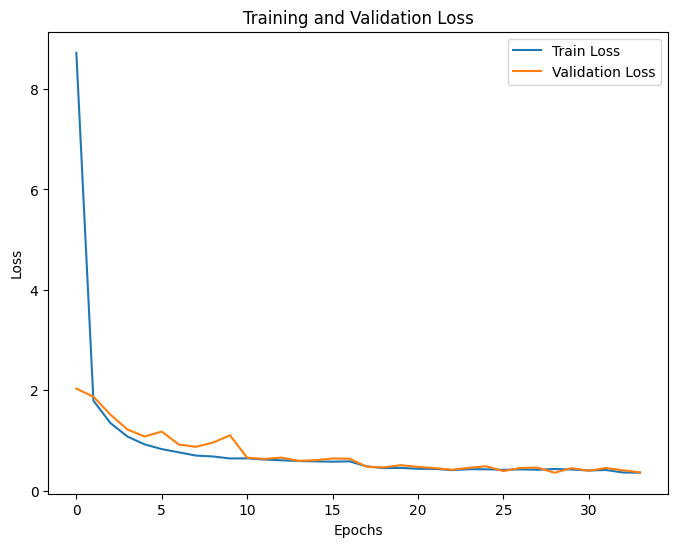

In [164]:
# Loss Plot
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_loss(history_high_acc)
